# Figure 3 - Overnight sequences

## 1. Helper functions and parameters

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from pipeline import read_timeseries

# ===================== Adjustable Parameters =====================
# bird_name           = 'ro'
reports_dir         = Path('.')
start_date          = None      # 'YYYY-MM-DD' or None
end_date            = None     # 'YYYY-MM-DD' or None
low_threshold       = 1          # for initial load
high_threshold      = 30
min_sequence_hours  = 5
max_gap_seconds     = 120
on_weight_threshold = 11
downsample_step     = 5
raw_filter_low      = 0.02
raw_filter_high     = 0.98
std_window_minutes  = 10        # for Fig2 rolling std
context_hours       = 1         # for Fig1 wide
# =================================================================

# ---------- Utility: reliable measure -----------
def calc_reliable_measure(seq,
                          win_size=10,
                          step=1,
                          weight_fraction=0.09):
    """
    Find windows of consecutive samples whose std < weight_fraction * mean_weight.
    Returns reliable_df, start_time, end_time, start_w, end_w.
    """
    w = seq['weight'].values
    t = seq['Time'].values
    means, stds, times_center = [], [], []
    for i in range(0, len(w) - win_size + 1, step):
        win = w[i:i+win_size]
        m, s = win.mean(), win.std()
        means.append(m); stds.append(s)
        times_center.append(t[i + win_size//2])
    means = np.array(means); stds = np.array(stds); times_center = np.array(times_center)

    ref = seq['weight'].mean()
    threshold = weight_fraction * ref
    idx = stds < threshold

    if idx.sum() < 2:
        # fallback: full sequence
        st = seq['Time'].iloc[0]
        en = seq['Time'].iloc[-1]
        # Use average of first and last 100 points (or all if less than 100)
        n = min(100, len(seq))
        sw = seq['weight'].iloc[:n].mean()
        ew = seq['weight'].iloc[-n:].mean()
    else:
        rel_times = times_center[idx]
        rel_means = means[idx]
        st, en = pd.to_datetime(rel_times[0]), pd.to_datetime(rel_times[-1])
        # Use average of first and last 100 points in the reliable region
        reliable_idx = np.where(idx)[0]
        n = min(100, len(reliable_idx))
        sw = means[reliable_idx[:n]].mean()
        ew = means[reliable_idx[-n:]].mean()

    reliable_df = pd.DataFrame({'Time': times_center[idx], 'Weight': means[idx]})
    return reliable_df, st, en, sw, ew

# ---------- Core functions ----------
def load_bird_data(
    name,
    low_thrd=low_threshold,
    high_thrd=high_threshold,
    start_date=start_date,
    end_date=end_date,
    keep_out_of_range=False
):
    df = read_timeseries(
        reports_dir / f"a_{name}_weight_report.csv",
        low_thrd=low_thrd,
        high_thrd=high_thrd,
        start_date=start_date,
        end_date=end_date,
        keep_out_of_range=keep_out_of_range
    )
    return df.sort_values('Time').reset_index(drop=True)

def find_all_sequences(df):
    d = df.copy()
    d['dt']    = d['Time'].diff().dt.total_seconds().fillna(0)
    d['On']    = d['weight'] > on_weight_threshold
    d['new']   = (d['On'] != d['On'].shift()) | (d['dt'] > max_gap_seconds)
    d['Group'] = d['new'].cumsum()

    meta = (
        d[d['On']]
        .groupby('Group')
        .agg(start=('Time','min'), end=('Time','max'))
        .assign(hours=lambda x: (x['end']-x['start']).dt.total_seconds()/3600)
        .query('hours >= @min_sequence_hours')
        .reset_index()
    )

    seqs = []
    for _, r in meta.iterrows():
        grp    = int(r['Group'])
        df_seq = d[(d['Group']==grp) & d['On']].copy().reset_index(drop=True)
        seqs.append({'Group': grp, 'df': df_seq,
                     'start': r['start'], 'end': r['end'],
                     'hours': r['hours']})
    return seqs

def compute_metrics(seq_dict, bird):
    seq = seq_dict['df']
    rel_df, st, en, sw, ew = calc_reliable_measure(seq)
    duration_h = (en - st).total_seconds() / 3600

    # regression on full raw seq
    X = (seq['Time'] - seq['Time'].iloc[0]).dt.total_seconds().values.reshape(-1,1)
    y = seq['weight'].values
    m = LinearRegression().fit(X, y)
    pred  = m.predict(X)
    slope = m.coef_[0] * 3600

    total_loss = sw - ew
    actual = load_actual_weight(bird, str(st.date()))
    pct      = total_loss / actual * 100 if actual else np.nan
    pct_hr   = slope / actual * 100      if actual else np.nan

    return {
        'bird':          bird,
        'start_time':    st,
        'end_time':      en,
        'start_w':       sw,
        'end_w':         ew,
        'hours':         duration_h,
        'total_loss':    total_loss,
        'loss_pct':      pct,
        'slope_hr':      slope,
        'pct_hr':        pct_hr,
        'pred':          pred,
        'actual_weight': actual
    }

def load_actual_weight(name, date):
    w = pd.read_csv('weights.csv', index_col=0)
    return float(w.at[name, date] if date in w.columns else w.at[name, 'mean'])

# ---------- Plotting functions ----------
def plot_fig1(df, seq, metrics, context_hours=3, downsample_step=5):
    """
    Plots raw weight around a sequence (± context_hours), with:
     - one line for the sequence’s overall mean (orange dashed)
     - one line for the bird’s actual weight     (red dash-dot)
     - scatter is downsampled by downsample_step
    """
    # time window around the reliable sequence
    start = metrics['start_time'] - pd.Timedelta(hours=context_hours)
    end   = metrics['end_time']   + pd.Timedelta(hours=context_hours)
    win   = df[(df['Time'] >= start) & (df['Time'] <= end)]

    # Downsample the window for scatter
    win_down = win.iloc[::downsample_step].copy()

    # compute the mean of the full sequence
    seq_mean = seq['weight'].mean()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(win_down['Time'], win_down['weight'],
               s=5, alpha=0.3, color='blue',
               label='raw data (downsampled)')

    # sequence overall mean
    ax.axhline(seq_mean,
               color='tab:green', linestyle='--', lw=1.5,
               label=f'seq mean ({seq_mean:.2f} g)')

    # # actual weight
    # ax.axhline(metrics['actual_weight'],
    #            color='red', linestyle='-.', lw=1.5,
    #            label=f'actual wt ({metrics["actual_weight"]:.2f} g)')

    ax.set_xlabel('Time')
    ax.set_ylabel('Weight (g)')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.legend(loc='best')
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax

def plot_fig2(seq, metrics, downsample_step=5, 
              raw_filter_low=0.01, raw_filter_high=0.99):
    """
    Plots downsampled weight data with a regression line and rolling std.
    """
    # Downsample & quantile‐filter
    down = seq.iloc[::downsample_step].copy()
    ql, qh = down['weight'].quantile(raw_filter_low), down['weight'].quantile(raw_filter_high)
    down = down[(down['weight']>=ql)&(down['weight']<=qh)].reset_index(drop=True)

    # Time axis in hours from start
    hours_down = (down['Time'] - seq['Time'].iloc[0]).dt.total_seconds() / 3600

    # Compute rolling std over 100-point window
    window_pts = 100
    stds = down['weight'].rolling(window_pts, center=True, min_periods=1).std()

    # Interpolate regression prediction to downsampled time axis
    hours_full = (seq['Time'] - seq['Time'].iloc[0]).dt.total_seconds() / 3600
    pred_interp = np.interp(hours_down, hours_full, metrics['pred'])

    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(hours_down, down['weight'], s=8, alpha=0.4, color='blue', label='data')
    ax.plot(hours_down, pred_interp, color='red', label=f'y={metrics["slope_hr"]:.2f}x + {pred_interp[0]:.2f} (g/h)', lw=1.5)

    # # Fill between ±1 std
    # ax.fill_between(hours_down, pred_interp-stds, pred_interp+stds,
    #                 color='red', alpha=0.3, label='rolling ±1 std (100 pts)')

    # Set y-limits to ±1g from the mean of the sequence
    seq_mean = seq['weight'].mean()
    ax.set_ylim(seq_mean - 1, seq_mean + 1)

    ax.set_xlabel('Hours from start')
    ax.set_ylabel('Weight (g)')
    ax.legend()
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax

def plot_all_sequences_for_bird(df, seqs, mets, ncols=2, figsize=(12,8), downsample_step=1, ylim_factor=0.15):
    """
    Plot all sequences for a bird in a grid layout.
    
    Parameters:
        df: Original DataFrame (not used in current implementation)
        seqs: List of sequence dictionaries with 'df' key
        mets: List of metrics dictionaries
        ncols: Number of columns in the grid
        figsize: Figure size tuple
        downsample_step: Step size for downsampling scatter points (default 1 = no downsampling)
        ylim_factor: Factor to set y-limits based on sequence mean (default 0.15 = 15%)
    """
    import math
    n = len(seqs); rows = math.ceil(n/ncols)
    fig, axes = plt.subplots(rows, ncols, figsize=figsize)
    axes = axes.flatten()
    for ax, sd, m in zip(axes, seqs, mets):
        s = sd['df']
        # Downsample the scatter data
        s_down = s.iloc[::downsample_step] if downsample_step > 1 else s
        ax.scatter(s_down['Time'], s_down['weight'], s=5, alpha=0.4)
        ax.plot(s['Time'], m['pred'], c='red', lw=1)
        ax.set_title(
            f"{m['bird']} {m['start_time'].date()}→{m['end_time'].date()}\n"
            f"Δ{m['total_loss']:.1f}g ({m['loss_pct']:.1f}%) {m['hours']:.1f}h"
        )
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax.grid(True, ls='--', alpha=0.5)

        # Set y-limits to ±15% of the sequence mean
        seq_mean = s['weight'].mean()
        y_margin = ylim_factor * seq_mean  # 15% of mean
        ax.set_ylim(seq_mean - y_margin, seq_mean + y_margin)
        
    for ax in axes[n:]: ax.axis('off')
    fig.tight_layout()
    return fig, axes

def plot_fig3(records, show_per_bird_avg=True):
    """
    Plots each bird’s regression trajectory.
    If show_per_bird_avg is True, shows the average line per bird.
    If False, shows all individual lines.
    The global regression fit (red) is computed only from sequences with negative slopes.
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10,4))
    birds = sorted({r['bird'] for r in records})
    cmap = plt.cm.tab10(np.linspace(0,1,len(birds)))
    color_map = dict(zip(birds, cmap))

    all_hours = []
    all_vals  = []
    neg_hours = []
    neg_vals  = []

    if show_per_bird_avg:
        # Plot average line per bird
        for i, bird in enumerate(birds):
            bird_recs = [r for r in records if r['bird'] == bird]
            max_h = max(r['hours'] for r in bird_recs)
            common_hrs = np.linspace(0, max_h, 200)
            interp_preds = []
            for r in bird_recs:
                hrs = np.linspace(0, r['hours'], len(r['pred']))
                interp = np.interp(common_hrs, hrs, r['pred'])
                interp_preds.append(interp)
                all_hours.append(hrs)
                all_vals.append(r['pred'])
                # Only use negative slopes for global fit
                if r['slope_hr'] < 0:
                    neg_hours.append(hrs)
                    neg_vals.append(r['pred'])
            mean_pred = np.mean(interp_preds, axis=0)
            ax.plot(common_hrs, mean_pred, color=color_map[bird], label=bird)
    else:
        # Plot all individual lines
        birds_plotted = set()
        for r in records:
            hrs = np.linspace(0, r['hours'], len(r['pred']))
            bird = r['bird']
            label = bird if bird not in birds_plotted else None
            ax.plot(hrs, r['pred'], color=color_map[bird], alpha=0.4, label=label)
            birds_plotted.add(bird)
            all_hours.append(hrs)
            all_vals.append(r['pred'])
            # Only use negative slopes for global fit
            if r['slope_hr'] < 0:
                neg_hours.append(hrs)
                neg_vals.append(r['pred'])
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='bird')

    # Fit global regression (only negative slopes)
    if neg_hours and neg_vals:
        X = np.concatenate(neg_hours).reshape(-1,1)
        y = np.concatenate(neg_vals)
        lr = LinearRegression().fit(X, y)
        max_h = max([r['hours'] for r in records])
        common_hrs = np.linspace(0, max_h, 200)
        fit_vals   = lr.predict(common_hrs.reshape(-1,1))
        ax.plot(common_hrs, fit_vals,
                color='red', linewidth=2,
                label=f'Global fit: slope={lr.coef_[0]:.2f} g/h')
    else:
        ax.text(0.5, 0.5, "No negative-slope sequences for global fit", transform=ax.transAxes,
                ha='center', va='center', color='red')

    ax.set_xlabel('Hours from start')
    ax.set_ylabel('Weight (g)')
    ax.legend(title='bird')
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax

def plot_fig4(records):
    fig, ax = plt.subplots(figsize=(6,4))
    xs = [r['actual_weight'] for r in records]
    ys = [-r['pct_hr'] for r in records]
    ax.scatter(xs, ys)
    ax.set_xlabel('Actual Weight (g)'); ax.set_ylabel('Per-cent of total weight lost per hour (%/h)')
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax

# 2. Generate overnight sequences summary table

In [ ]:
# ── Code cell: Assemble sequences into a DataFrame ──
import pandas as pd

# Adjustable parameters (if you want to override defaults here)
start_date         = None
end_date           = None
low_threshold      = 1
high_threshold     = 30

bird_names = ['ro', 'ly2rp9', 'lp92llb8', 'lp114w8rb', 'llb84b35']  # extend as needed

rows = []
all_recs = []
for bird in bird_names:
    df = load_bird_data(bird, 
                          low_thrd=low_threshold, high_thrd=high_threshold,
                          start_date=start_date, end_date=end_date)
    seqs = find_all_sequences(df)
    if not seqs:
        continue
    mets = [compute_metrics(sd, bird) for sd in seqs]
    for i, (s, m) in enumerate(zip(seqs, mets)):
        # Add all available data from metrics dictionary except 'pred'
        row = {
            'bird':           bird,
            'sequence_idx':   i,
            'start_time':     s['start'],
            'end_time':       s['end'],
            'duration_h':     s['hours'],
        }
        row.update({k: v for k, v in m.items() if k != 'pred'})
        rows.append(row)
        all_recs.append(m)

df_sequences = pd.DataFrame(rows)

df_sequences

# Optionally export to CSV (uncomment to save)
# df_sequences.to_csv('overnight_sequences_metadata.csv', index=False)

NameError: name 'load_bird_data' is not defined

## 2.2 - calculate metrics from summary table

In [ ]:

path_to_figures = Path('figures')
# Read overnight metadata df
df_sequences = pd.read_csv('overnight_sequences_metadata.csv', parse_dates=['start_time', 'end_time'])
# Calculate the mean and sd of slope_hr for negative slopes
neg_slopes = df_sequences[df_sequences['slope_hr'] < 0]['slope_hr'].reset_index(drop=True)
mean_neg_slope = neg_slopes.mean()
std_neg_slope = neg_slopes.std()
print(len(neg_slopes), "negative-slope sequences found.")
print(f"Mean of negative slopes: {mean_neg_slope:.2f} g/h")
print(f"Standard deviation of negative slopes: {std_neg_slope:.2f} g/h")

# read 'overnight_sequences_metadata.csv' and calculate the average weight loss per hour across all negative slope sequences
import pandas as pd
import numpy as np
# Load the metadata CSV
metadata_file = 'overnight_sequences_metadata.csv'
df_metadata = pd.read_csv(metadata_file)
# Filter for negative slope sequences
negative_slope_sequences = df_metadata[df_metadata['slope_hr'] < 0]
print(f"Number of negative slope sequences: {len(negative_slope_sequences)}")
# Calculate the average weight loss per hour across all negative slope sequences
avg_loss_per_hour = negative_slope_sequences['pct_hr'].mean()
print(f"Average weight loss per hour (negative slope): {avg_loss_per_hour:.2f}%")

# calculate average percentage of weight loss in total (loss_pct) across all negative slope sequences
avg_total_loss_pct = negative_slope_sequences['loss_pct'].mean()
print(f"Average total weight loss percentage (loss_pct) across all negative slope sequences: {avg_total_loss_pct:.2f}%")

22 negative-slope sequences found.
Mean of negative slopes: -0.07 g/h
Standard deviation of negative slopes: 0.02 g/h


## 3 - generate panel A 

Note that what is called figure 1 + figure 2 here are both part of Panel A of the Figure (Figure 3). Change the names accordingly. 
What is called figure 3 in the next part is Panel B. 

Selected bird: lp92llb8, sequence index: 3
(209362, 2) (685880, 2) 4 4


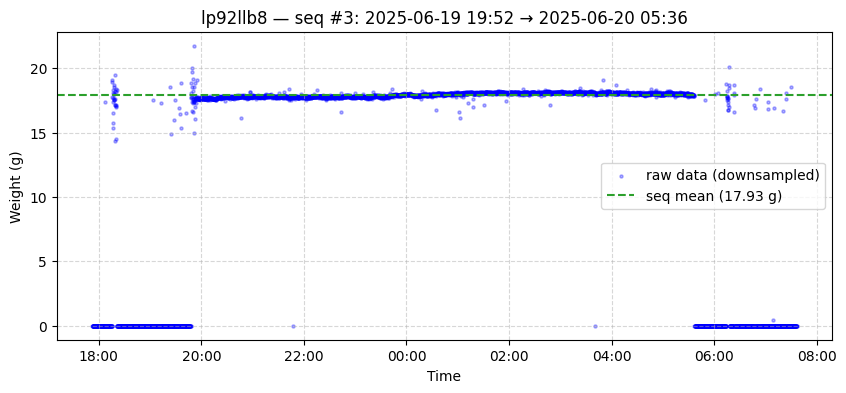

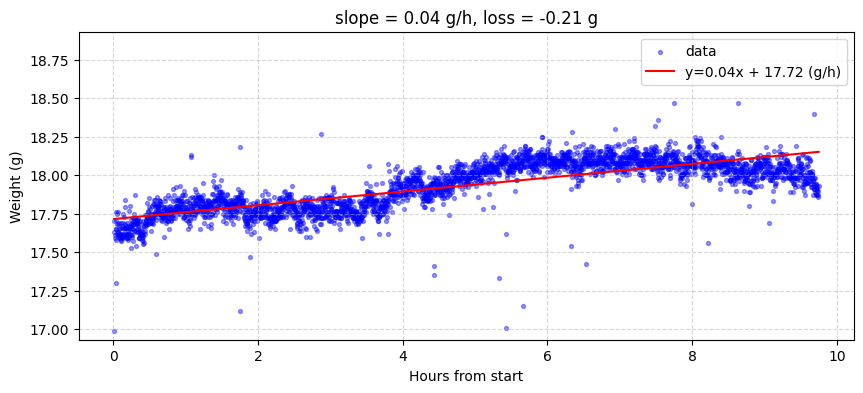

In [38]:
# ── Code cell: Figures 1 & 2 (interactive via df_sequences) ──
import matplotlib.pyplot as plt
path_to_figures = Path('figures')
# Read overnight metadata df
df_sequences = pd.read_csv('overnight_sequences_metadata.csv', parse_dates=['start_time', 'end_time'])
# print(df_sequences.columns)
# print(df_sequences.shape)
# print("Range of negative slopes:")
# print(df_sequences[df_sequences['slope_hr'] < 0]['slope_hr'].describe())

# 1) Select which sequence to plot by DataFrame index:
selection_index = 17   # ← change this to the df_sequences index you want

# 2) Extract bird & sequence index from df_sequences
row     = df_sequences.iloc[selection_index]
bird    = row['bird']
seq_idx = row['sequence_idx']

# Define downsample step for plotting
downsample_step = 8  # how much to downsample the raw data for plotting

# 3) Reload data, detect sequences, and compute metrics for that bird
df_filtered = load_bird_data(bird, low_thrd=1, high_thrd=30)  # uses defaults
df_unfiltered = load_bird_data(bird, low_thrd=0, high_thrd=30, start_date=None, end_date=None)
seqs  = find_all_sequences(df_filtered)
mets  = [compute_metrics(sd, bird) for sd in seqs]

print(f"Selected bird: {bird}, sequence index: {seq_idx}")
print(df_filtered.shape, df_unfiltered.shape, len(seqs), len(mets))
# 4) Generate Figure 1: context-zoomed raw + start/end means (use unfiltered data)
fig1, ax1 = plot_fig1(df_unfiltered, seqs[seq_idx]['df'], mets[seq_idx], downsample_step=downsample_step, context_hours=2)
ax1.set_title(
    f"{bird} — seq #{seq_idx}: {row['start_time'].strftime('%Y-%m-%d %H:%M')} → {row['end_time'].strftime('%Y-%m-%d %H:%M')}"
)
fig1_save_name = path_to_figures / f"overnight_panel_A.svg"
# plt.savefig(fig1_save_name, bbox_inches='tight', dpi=300, format='svg')

# 5) Generate Figure 2: downsampled & regression + rolling std (use filtered data)
fig2, ax2 = plot_fig2(seqs[seq_idx]['df'], mets[seq_idx], downsample_step=downsample_step, raw_filter_low=0.001, raw_filter_high=0.999)
ax2.set_title(
    f"slope = {mets[seq_idx]['slope_hr']:.2f} g/h, loss = {mets[seq_idx]['total_loss']:.2f} g"
)
fig2_save_name = path_to_figures / f"overnight_panel_B.svg"
# plt.savefig(fig2_save_name, bbox_inches='tight', dpi=300, format='svg')
# 6) Display both
plt.show()


# 4. generate panel B 
change the name of function from figure 3 to panel b...


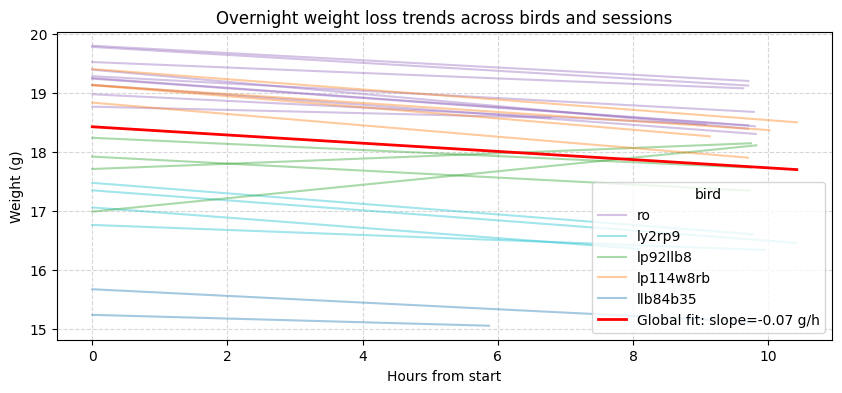

In [ ]:
# ── Code cell: Figure 3 ──
# Multi‐bird aggregation: regression trajectories over time

def plot_fig3(records, show_per_bird_avg=True):
    """
    Plots each bird’s regression trajectory.
    If show_per_bird_avg is True, shows the average line per bird.
    If False, shows all individual lines.
    The global regression fit (red) is computed only from sequences with negative slopes.
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10,4))
    birds = sorted({r['bird'] for r in records})
    # cmap = plt.cm.tab10(np.linspace(0,1,len(birds)))
    # color_map = dict(zip(birds, cmap))
    bird_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:purple', 'tab:brown']
    color_map = dict(zip(birds, bird_colors))

    all_hours = []
    all_vals  = []
    neg_hours = []
    neg_vals  = []

    if show_per_bird_avg:
        # Plot average line per bird
        for i, bird in enumerate(birds):
            bird_recs = [r for r in records if r['bird'] == bird]
            max_h = max(r['hours'] for r in bird_recs)
            common_hrs = np.linspace(0, max_h, 200)
            interp_preds = []
            for r in bird_recs:
                hrs = np.linspace(0, r['hours'], len(r['pred']))
                interp = np.interp(common_hrs, hrs, r['pred'])
                interp_preds.append(interp)
                all_hours.append(hrs)
                all_vals.append(r['pred'])
                # Only use negative slopes for global fit
                if r['slope_hr'] < 0:
                    neg_hours.append(hrs)
                    neg_vals.append(r['pred'])
            mean_pred = np.mean(interp_preds, axis=0)
            ax.plot(common_hrs, mean_pred, color=color_map[bird], label=bird)
    else:
        # Plot all individual lines
        birds_plotted = set()
        for r in records:
            hrs = np.linspace(0, r['hours'], len(r['pred']))
            bird = r['bird']
            label = bird if bird not in birds_plotted else None
            ax.plot(hrs, r['pred'], color=color_map[bird], alpha=0.4, label=label)
            birds_plotted.add(bird)
            all_hours.append(hrs)
            all_vals.append(r['pred'])
            # Only use negative slopes for global fit
            if r['slope_hr'] < 0:
                neg_hours.append(hrs)
                neg_vals.append(r['pred'])
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='bird')

    # Calculate the average slope and intercept for the global fit
    if neg_hours and neg_vals:
        slopes = [r['slope_hr'] for r in records if r['slope_hr'] < 0]
        intercepts = [r['pred'][0] for r in records if r['slope_hr'] < 0]  # First predicted value as intercept
        avg_slope = np.mean(slopes)
        avg_intercept = np.mean(intercepts)

        # Generate the global fit line using the average slope and intercept
        max_h = max([r['hours'] for r in records])
        common_hrs = np.linspace(0, max_h, 200)
        fit_vals = avg_slope * common_hrs + avg_intercept

        # Plot the global fit line
        ax.plot(common_hrs, fit_vals,
                color='red', linewidth=2,
                label=f'Global fit: slope={avg_slope:.2f} g/h')

    ax.set_xlabel('Hours from start')
    ax.set_ylabel('Weight (g)')
    ax.legend(title='bird')
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax


# plot and show Figure 3
if all_recs:
    fig3, ax3 = plot_fig3(all_recs, show_per_bird_avg=False)
    ax3.set_title("Overnight weight loss trends across birds and sessions")
    fig4_save_name = path_to_figures / "overnight_panel_C.svg"
    plt.savefig(fig4_save_name, bbox_inches='tight', dpi=300, format='svg')
    plt.show()
else:
    print("No multi‐bird records found.")

# 5 - plot for Supporting Information figure S2 

In [ ]:
# # ── Code cell: Grid of All Sequences ──
# # Lay out scatter + regression for every on‐scale sequence

# # assuming df, seqs, mets are already in memory
# fig_grid = plot_all_sequences_for_bird(df, seqs, mets, ncols=2, figsize=(12,8))
# plt.show()

# ── Code cell: Compare a single bird’s sequence grid ──
# Change bird_name here to compare different birds:
# bird_name = 'lp92llb8'  # e.g. 'ro', 'mo', 'jo', etc.
bird_id = '3'
# Load data, detect sequences, compute metrics, and plot grid
df    = load_bird_data(bird_id)
seqs  = find_all_sequences(df)
if not seqs:
    raise RuntimeError(f'No sequences for bird number "{bird_id}"')

# Compute metrics for each sequence
mets = [compute_metrics(sd, bird_id) for sd in seqs]

downsample_step = 8  # how much to downsample the raw data for plotting

# Plot grid of all on-scale sequences for this bird
fig_grid = plot_all_sequences_for_bird(df, seqs, mets, ncols=2, figsize=(12,8), downsample_step=downsample_step, ylim_factor=0.1)

plt.suptitle(f"Weight sequences for bird '{bird_id}'", y=1.02)

# Save as svg
fig_grid_save_name = path_to_figures / f"overnight_{bird_id}_grid.svg"
plt.savefig(fig_grid_save_name, bbox_inches='tight', dpi=300, format='svg')

plt.show()

